In [1]:

# Import libraries

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2.8.2


In [2]:
from google.colab import drive
drive.mount('/ShardDrives/',force_remount=True)

Mounted at /ShardDrives/


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1f4f1826-d772-757f-3ac0-4b5a303d851a)


In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/ShardDrives/MyDrive/ds/train'
valid_path = '/ShardDrives/MyDrive/ds/test'

# Normalize your data

train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

target_size = (224,224)

In [5]:
# Generate batches of tensor image data for training

train_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical')

Found 7068 images belonging to 3 classes.


In [6]:
# Generate batches of tensor image data for validation

val_data_gen = val_datagen.flow_from_directory(valid_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False)

Found 771 images belonging to 3 classes.


In [7]:
# Filter warnings

import warnings
warnings.filterwarnings('ignore')

{'b': 0, 'n': 1, 'v': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

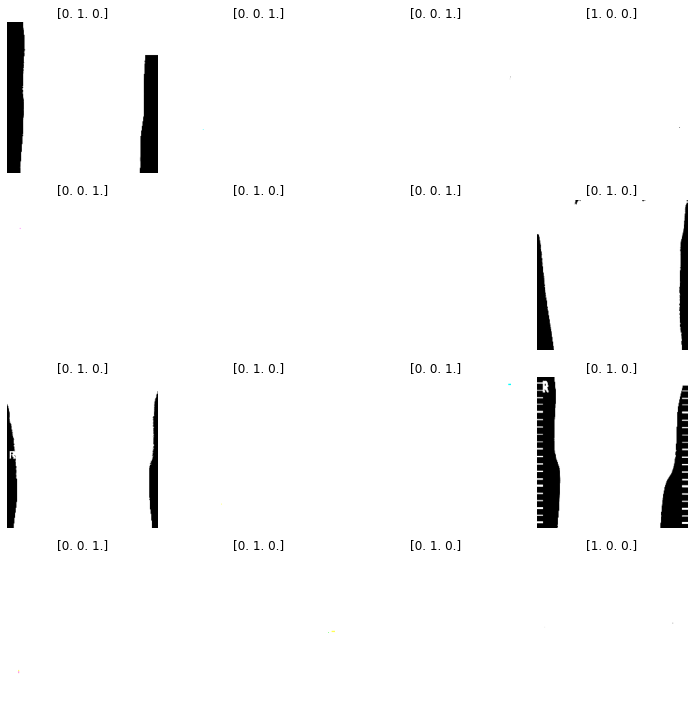

In [8]:
# Visualize samples of training images

class_labels = train_data_gen.class_indices
print(class_labels)

sample_training_images, labels = next(train_data_gen)

def plotImages(images_arr, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, lbs, ax in zip( images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbs)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:16], labels[:16])

In [9]:
# Import the Xception model

from tensorflow.keras.applications.xception import Xception

In [10]:
# Define your pre-trained model

input_shape = (224,224,3)
pretrained_model = Xception(input_shape = input_shape,
                weights = 'imagenet',
                
                include_top = False)
pretrained_model.trainable = False

83697664/83683744 [==============================] - 0s 0us/step


In [11]:
# Make the last three layers trainable for fine-tuning

for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

In [12]:
# Define your model

model = Sequential()

model.add(pretrained_model)

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
 activation_1 (Activation)   (None, 3)                 0

In [13]:
# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
patience=20)

mc = ModelCheckpoint('covid_19_xception2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [14]:
# Compile and fit your model

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

epochs = 100
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=train_data_gen.samples/train_data_gen.batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=val_data_gen.samples/val_data_gen.batch_size,
                              callbacks=[es,mc] )

Epoch 1/100
221/220 [==============================] - ETA: -2s - loss: 8.5314 - accuracy: 0.5764
Epoch 1: val_accuracy improved from -inf to 0.60182, saving model to covid_19_xception2.h5
220/220 [==============================] - 4674s 21s/step - loss: 8.5314 - accuracy: 0.5764 - val_loss: 0.8527 - val_accuracy: 0.6018
Epoch 2/100
221/220 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.6043
Epoch 2: val_accuracy improved from 0.60182 to 0.67575, saving model to covid_19_xception2.h5
220/220 [==============================] - 95s 431ms/step - loss: 0.8350 - accuracy: 0.6043 - val_loss: 0.7497 - val_accuracy: 0.6757
Epoch 3/100
221/220 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.5900
Epoch 3: val_accuracy improved from 0.67575 to 0.67704, saving model to covid_19_xception2.h5
220/220 [==============================] - 97s 438ms/step - loss: 0.8136 - accuracy: 0.5900 - val_loss: 0.8135 - val_accuracy: 0.6770
Epoch 4/100
221/220 [======

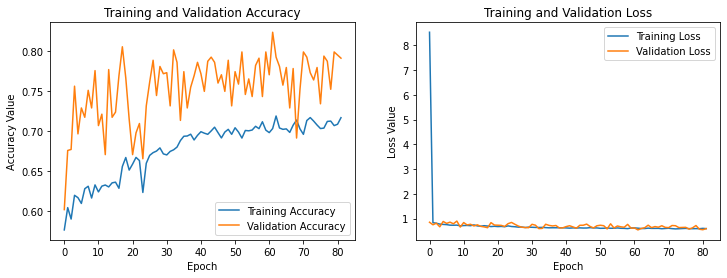

In [17]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Evaluate your model with confusion matrix and classification report

class_labels = train_data_gen.class_indices
print(class_labels)
print('\n')

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(val_data_gen, val_data_gen.samples // val_data_gen.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix \n')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('\n')
print('Classification Report \n')

print(classification_report(val_data_gen.classes, y_pred))

{'b': 0, 'n': 1, 'v': 2}


Confusion Matrix 

[[206   9  27]
 [  7 221  77]
 [ 22  10 192]]


Classification Report 

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       242
           1       0.92      0.72      0.81       305
           2       0.65      0.86      0.74       224

    accuracy                           0.80       771
   macro avg       0.82      0.81      0.80       771
weighted avg       0.83      0.80      0.81       771



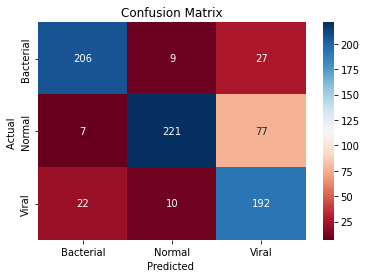

In [19]:
import seaborn as sns
cm=confusion_matrix(val_data_gen.classes, y_pred)
ax=sns.heatmap(cm,annot=True,cmap='RdBu',fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual ')
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
ax.yaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
plt.show()

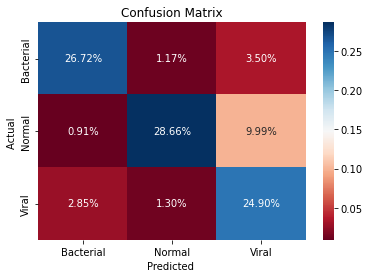

In [21]:
import seaborn as sns
ax=sns.heatmap(cm/np.sum(cm),annot=True,cmap='RdBu',fmt='.2%')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual ')
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
ax.yaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
plt.show()

In [22]:

# save it as a h5 file


from tensorflow.keras.models import load_model

FLOW1_model=model.save('xception_001.h5')

In [29]:
from sklearn.metrics import accuracy_score

xception_acc = accuracy_score(val_data_gen.classes, y_pred)
print("Xception Model Accuracy with Fine-Tuning: {:.2f}%".format(xception_acc * 100))

Xception Model Accuracy with Fine-Tuning: 80.29%


In [28]:
from google.colab import files
files.download("xception_001.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>